# Determining genotypes

This excersize aims at applying Bayesian statistics to calculate the probability of a specific genotype. In particular we will:
1. Combine two .
2. Compare the computed results with simple simulations.

The exercise is made to play around with a simulated sample of genes and DNA. The goal is to calculate the probability of an original state, based on data and prior probability.

### References:
- Lecture on Bayesian statistics
- Lecture on Markov Chains

### Authors: 
- Mathias L. Heltberg (Niels Bohr Institute)

### Date:    
- 29-12-2021 (latest update)

***

As always we will include a collection of libraries (Standard)

In [497]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

We will also (big surprise...) need a random generator:

In [498]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

And now for the actual problem: You are given a sample of a particular gene (for simplicity say eyecolor). This gene is found in two versions: A and B. Given that we all have DNA from our fathers and mothers, there are 3 possibilities of combinations for genotypes: AA, AB and BB.

So say you measure everything optimally, if you have 8 versions of the gene, coming from AB it might look like: 
- [A,B,A,B,A,A,A,B]

However, you don't have the best equipment and there is a possibility that you measure a gene wron. This is given by a matrix, XX.


.............................................................................................................................................................................................................

Assume you get the sequence: [A,A,A,A,B]. We want to compute the probability for each of the three genotypes given sequences of data.

.............................................................................................................................................................................................................

Start by writing on paper, thinking about how you would calculate this probability.

Information 1: The matrix of transformations (meaning the probability that your machine measures A if it was really a B), takes the form:

In [522]:
XX = np.zeros((2,2)); XX[0,0] = 0.85; XX[0,1] = 0.15; XX[1,0] = 0.05; XX[1,1] = 0.95;
print("XX (i.e. the matrix of transformations error) = ")
print(XX)

XX (i.e. the matrix of transformations error) = 
[[0.85 0.15]
 [0.05 0.95]]


Information 2: You know that in the population, there are the probabilities for each combination:
- AA = 0.45
- BB = 0.40
- AB = 0.15

In [523]:
Pri = np.zeros(3); Pri[0] = 0.45; Pri[1] = 0.15; Pri[2] = 0.40;
print("Prior = ")
print(Pri)

Prior = 
[0.45 0.15 0.4 ]


In [524]:
S = np.zeros((2,3)); 
S[0,0] = 2./3; S[0,1] = 1./3; S[1,1] = 1./3; S[1,2] = 2./3 ## Matrix to end up in a genotype
print("S = ")
print(S)

S = 
[[0.66666667 0.33333333 0.        ]
 [0.         0.33333333 0.66666667]]


We can now construct a full matrix of the seven states:

In [525]:
M = np.zeros((7,7)); M[0:2,2:4] = np.transpose(XX); M[2:4,4:] = S; 
print("M = ")
print(M)

M = 
[[0.         0.         0.85       0.05       0.         0.
  0.        ]
 [0.         0.         0.15       0.95       0.         0.
  0.        ]
 [0.         0.         0.         0.         0.66666667 0.33333333
  0.        ]
 [0.         0.         0.         0.         0.         0.33333333
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


So what is the probability a measured base B comes from the genotype BB?

In [526]:
V1 = np.zeros(2); V1[1] = 1;
XX2 = np.transpose(XX) 
P = np.matmul(V1,np.matmul(XX2,S)); 
print(P)

[0.1        0.36666667 0.63333333]


Think about why do we use the transposed matrix? 

So now the probability that the sequence [A,A,A,A,B] comes from the 3 genotypes must bu the product of these probabilities (think about why this has to be the case):

In [527]:
Seq = [0,0,0,0,1]
LLout = np.ones(3)
LLoutFull = np.ones(3)
for igeno in range(3):    
    V2 = np.zeros(3); V2[igeno]= 1;
    V2Full = np.zeros(7); V2Full[4+igeno]= 1;
    for iseq in range(len(Seq)):
        V1Full = np.zeros([1,7]); V1Full[0,Seq[iseq]] = 1;
        LLoutFull[igeno] *= np.matmul(np.matmul(V1Full,np.linalg.matrix_power(M,2)),V2Full)
        V1 = np.zeros([1,2]); V1[0,Seq[iseq]] = 1;        
        LLout[igeno] *= np.matmul(np.matmul(V1,np.matmul(XX2,S)),V2)
        

Note that we could use the full matrix and square it, and we could use the combination of our XX matrix and S. These give the same:

In [528]:
print("The likelihood using the squared matrix is:")
print(LLoutFull)
print("The likelihood using the two submatrices is:")
print(LLout)

The likelihood using the squared matrix is:
[1.03112346e-02 2.97000000e-03 7.81893004e-07]
The likelihood using the two submatrices is:
[1.03112346e-02 2.97000000e-03 7.81893004e-07]


Now we should produce a probability based on this likelihood. We can get a probability by including the prior or not - but these results differ of course!

In [529]:
print("Probabilities with the included prior ")
for i in range(3):
    print(LLout[i]/np.dot(LLout,Pri)*Pri[i])
print(" ")
print("Probabilities without the included prior ")
for i in range(3):
    print(LLout[i]/np.sum(LLout))

Probabilities with the included prior 
0.9123428429943053
0.08759566166558512
6.149534010968829e-05
 
Probabilities without the included prior 
0.776330506610318
0.2236106248431463
5.886854653558605e-05


So now we have obtained the predicted probabilites based on our calculations.

Lets make a simulation to test if this is true!

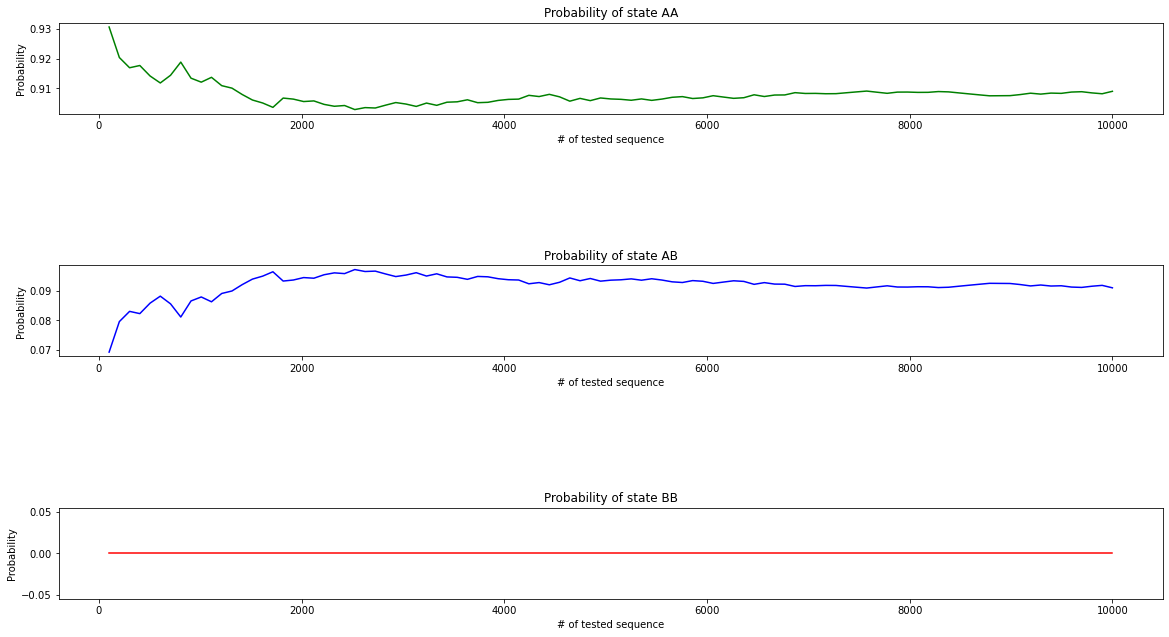

In [530]:
c = 0 ## counter 
nsave = 100 ## 100 datapoints to save - only for plotting!
lseq = 5 ## length of the sequence
Ntest = 10000 ## Number of points to generate
PlAr = np.zeros((nsave,3))
ntrue = np.zeros(Ntest) ## array where we save the actual genotype that gave rise to a sequence
ns = np.zeros(5) ## Here we put the test-sequence for all runs
click = 1

while(c<Ntest):
    A = np.random.random() ## This is a random number to determine genotype    
    if (A<Pri[0]): ## For genotype AA
        ntrue[c] = 0
        for i in range(lseq):
            B = np.random.random()
            if (B<XX[0,0]):
                ns[i] = 0
            else:
                ns[i] = 1
    elif (A<Pri[0]+Pri[1]): ## For genotype AB
        ntrue[c] = 1
        for i in range(lseq):
            if (np.random.random()<0.5):
                B = np.random.random()
                if (B<XX[0,0]):
                    ns[i] = 0
                else:
                    ns[i] = 1
            else: 
                B = np.random.random()
                if (B<XX[1,0]):
                    ns[i] = 0
                else:
                    ns[i] = 1
    else: ## For genotype BB
        ntrue[c] = 2
        for i in range(lseq):
            B = np.random.random()
            if (B<XX[1,0]):
                ns[i] = 0
            else:
                ns[i] = 1
                
    if (np.sum(ns) == 1): ## If our simulated sequence matches the desired sequence
        c+= 1
        
        if (c > click*Ntest/nsave): 
            l1 = np.ones(c)
            PlAr[click,0] = np.sum(l1[ntrue[0:c]==0])/len(ntrue[0:c])
            PlAr[click,1] = np.sum(l1[ntrue[0:c]==1])/len(ntrue[0:c])
            PlAr[click,2] = np.sum(l1[ntrue[0:c]==2])/len(ntrue[0:c])            
            click+=1

fig, ax = plt.subplots(3)
ax[0].plot(np.linspace(1*Ntest/nsave,Ntest,nsave-1),PlAr[1:,0],'-g')
ax[0].set_xlabel('# of tested sequence')
ax[0].set_ylabel('Probability')
ax[0].set_title('Probability of state AA')

ax[1].plot(np.linspace(1*Ntest/nsave,Ntest,nsave-1),PlAr[1:,1],'-b')
ax[1].set_xlabel('# of tested sequence')
ax[1].set_ylabel('Probability')
ax[1].set_title('Probability of state AB')

ax[2].plot(np.linspace(1*Ntest/nsave,Ntest,nsave-1),PlAr[1:,2],'-r')
ax[2].set_xlabel('# of tested sequence')
ax[2].set_ylabel('Probability')
ax[2].set_title('Probability of state BB')
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)

In [531]:
l1 = np.ones(len(ntrue))
print("When we measure a sequence [A,A,A,A,B] the fractions of genotypes are:")
print(np.sum(l1[ntrue==0])/len(ntrue))
print(np.sum(l1[ntrue==1])/len(ntrue))
print(np.sum(l1[ntrue==2])/len(ntrue))

When we measure a sequence [A,A,A,A,B] the fractions of genotypes are:
0.9094
0.0906
0.0


Clearly this agrees well with the calculated result when we use the prior!

Below here, this code can be used to calculate the probabilities by updating the prior:

In [532]:
######### Try to make an updated prior ##########
Seq = [0,0,0,0,1]
LLout = np.ones(3)
XX2 = np.transpose(XX) 
Pri0 = np.zeros(3); Pri0[0] = 0.45; Pri0[1] = 0.15; Pri0[2] = 0.40;
for iseq in range(len(Seq)): 
    V1 = np.zeros([1,2]); V1[0,Seq[iseq]] = 1;        
    LLout = np.matmul(V1,np.matmul(XX2,S))
    Pout = 0 ####### You write here but use Pri0
    

This piece of code can be used to generate sequences of length Nseq in order to calculate the probabilities for the questions.

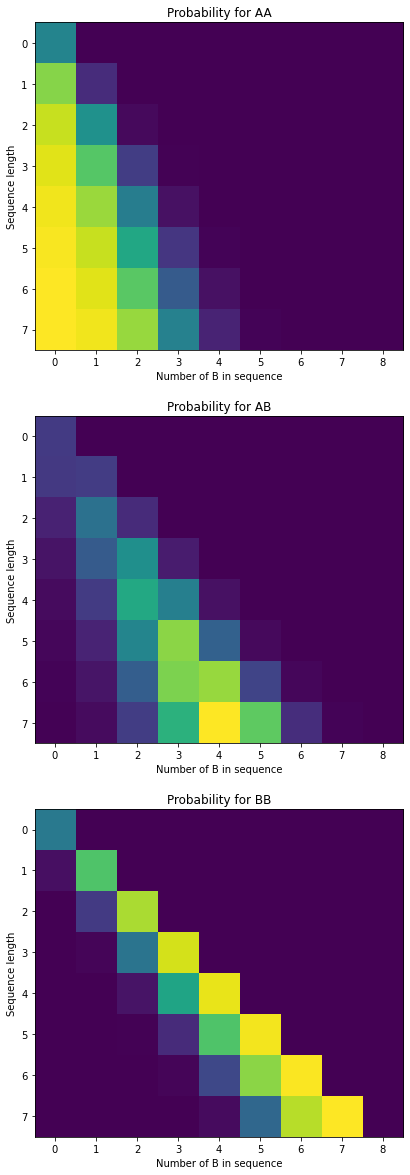

In [540]:
######### Generate probabilities of arbitrary length ##########
Nseq = 8
ProbAA = np.zeros((Nseq,Nseq+1))
ProbAB = np.zeros((Nseq,Nseq+1))
ProbBB = np.zeros((Nseq,Nseq+1))
MaxProb = np.zeros((Nseq,Nseq+1))
for tseq in range(Nseq): 
    Seq = np.zeros(tseq, dtype=int)
    for vseq in range(tseq+1):
        if (vseq > 0):
            Seq[vseq-1] = 1
        LLout = np.ones(3)    
        for iseq in range(tseq): 
            V1 = np.zeros([1,2]); V1[0,Seq[iseq]] = 1;   
            L1 = np.matmul(V1,np.matmul(XX2,S))
            LLout *= L1.flatten()
        ProbAA[tseq,vseq] = LLout[0]/np.dot(LLout,Pri)*Pri[0]
        ProbAB[tseq,vseq] = LLout[1]/np.dot(LLout,Pri)*Pri[1]
        ProbBB[tseq,vseq] = LLout[2]/np.dot(LLout,Pri)*Pri[2]
        MaxProb[tseq,vseq] = np.max(LLout/np.dot(LLout,Pri)*Pri)
        
fig, ax = plt.subplots(3)
ax[0].set_title('Probability for AA')
ax[0].imshow(ProbAA)
ax[0].set_aspect('equal')
ax[0].set_xlabel('Number of B in sequence')
ax[0].set_ylabel('Sequence length')

ax[1].set_title('Probability for AB')
ax[1].imshow(ProbAB)
ax[1].set_aspect('equal')
ax[1].set_xlabel('Number of B in sequence')
ax[1].set_ylabel('Sequence length')

ax[2].set_title('Probability for BB')
ax[2].imshow(ProbBB)
ax[2].set_aspect('equal')
ax[2].set_xlabel('Number of B in sequence')
ax[2].set_ylabel('Sequence length')

#fig.tight_layout()
fig.set_size_inches(28.5, 20.5)

For the original values - why is the P(BB) band more narrow than the P(AA)?

Here we can calculate some relevant probabilities, for instance the maximal probability of AB and the minimal value of the most probable sequence of bases for each length of sequences (make sure you understand this).

Text(0, 0.5, 'Sequence length')

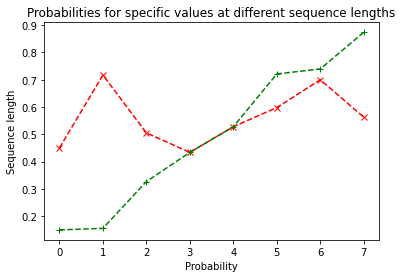

In [545]:
MinProb = np.zeros(Nseq)
MaxProbAB = np.zeros(Nseq)
for i in range(Nseq):
    MinProb[i] = np.min(MaxProb[i,0:i+1])
    MaxProbAB[i] = np.max(ProbAB[i,0:i+1])
plt.plot(MinProb,'--xr')
plt.plot(MaxProbAB,'--+g')
plt.title('Probabilities for specific values at different sequence lengths')
plt.xlabel('Probability')
plt.ylabel('Sequence length')

# Questions:

This excersize should make you think of how to combine two different types of uncertainty with the concept of a bayesian prior.

1) Try to change the sequence of length 5 so no genotype probability is larger than 0.66? Can you make a sequence of length 10 that does not have any probability larger than 0.66?

2) For the sequence of length 5: What happens if you update the prior for each base you are reading? Does it give the same result?

3) Assume for this question that the priors P(AA) = P(BB) = 0.49. How long a sequence do you need to make the call (p>0.95) of a the genotype AB if you have equal number of A's and B's?

4) Assume again that the priors P(AA) = P(BB) = 0.49 but that the matrix XX now has the values 
- XX[0,0] = 0.99. 
- XX[1,0] = 0.01. 
- XX[0,1] = 0.01. 
- XX[1,1] = 0.99. 

For the sequence: [A,A,A,A,B] - does the prior change the result in an important way? 

5) Lets say you are in charge of deciding the strategy of the lab department that should determine genotypes. Use the original prior. 
- How much do you need to improve the measurement accuracy, if you want p>0.95 for all sequences of length 10?

### Advanced question:

6) Assume that you had a 10% error in one of the measurement estimates (i.e. the entries in the matrix XX). Which one would afffect the probabilites the most?
